<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классификации комментариев на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
pip install colorama -q

In [2]:
pip install fsspec==2025.3.2 -q

In [3]:
pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

In [4]:
!pip install chardet -q

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import psutil
import gc
import time
from colorama import Fore, Back, Style
from functools import partial
import os
import chardet
import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from scipy.stats import loguniform
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch.cuda.amp as amp

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Подготовка
Загрузим данные, после чего лемматизируем и токенизируем их, поделим их на тестовую и тренировочную выборки.

In [7]:
with open('/content/toxic_comments.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))

print("Определённая кодировка:", result['encoding'])


df = pd.read_csv('/content/toxic_comments.csv', encoding=result['encoding'], on_bad_lines='skip', engine='python')
df

Определённая кодировка: utf-8


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


from matplotlib import pyplot as plt
df['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['toxic'].plot(kind='hist', bins=20, title='toxic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Unnamed: 0', y='toxic', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['toxic']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Unnamed: 0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('toxic')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unnamed: 0']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unnamed: 0'}, axis=1)
              .sort_values('Unnamed: 0', ascending=True))
  xs = counted['Unnamed: 0']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Unnamed: 0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['toxic'].plot(kind='line', figsize=(8, 4), title='toxic')
plt.gca().spines[['top', 'right']].set_visible(False)

Распределение классов:
toxic
0    89.838787
1    10.161213


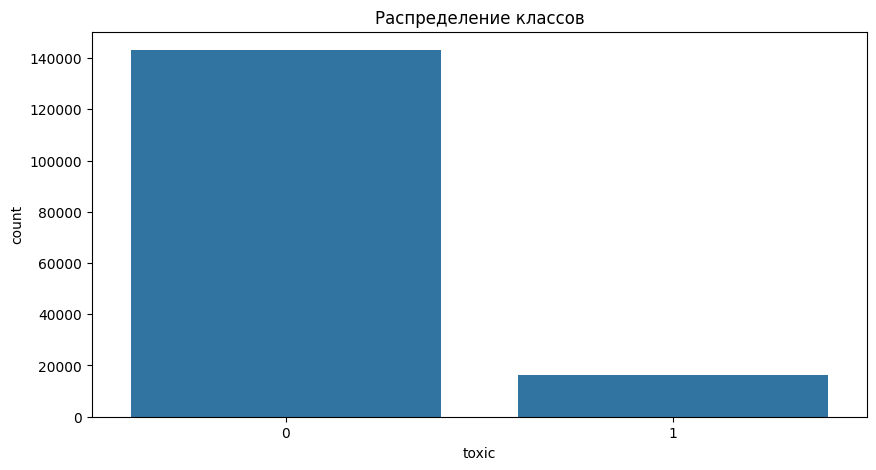

In [8]:
def analyze_class_balance(y):
    balance = pd.Series(y).value_counts(normalize=True) * 100
    print(f"Распределение классов:\n{balance.to_string()}")

    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title('Распределение классов')
    plt.show()

analyze_class_balance(df['toxic'])

Теперь мы видим что обьектов с классом 0 то есть нетоксичных твитов гораздо больше.

Данные загружены

In [9]:
os.system('')  


def load_spacy_model():
    print(Fore.YELLOW + "╔════════════════════════════════════════╗")
    print("║" + Fore.CYAN + "          ЗАГРУЗКА МОДЕЛИ SPACY          " + Fore.YELLOW + "║")
    print("╚════════════════════════════════════════╝" + Style.RESET_ALL)

    start_time = time.time()

    # Индикатор загрузки
    def loading_animation():
        chars = "⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏"
        while not hasattr(load_spacy_model, 'model_loaded'):
            for char in chars:
                print(Fore.GREEN + f"\r{char} Загрузка модели..." + Style.RESET_ALL, end="")
                time.sleep(0.1)

    import threading
    threading.Thread(target=loading_animation, daemon=True).start()

    try:
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "senter"])
        load_spacy_model.model_loaded = True
        end_time = time.time()
        print(Fore.GREEN + f"\r✓ Модель загружена за {end_time-start_time:.1f} секунд" + " " * 30 + Style.RESET_ALL)
        return nlp
    except Exception as e:
        print(Fore.RED + f"\r✗ Ошибка загрузки модели: {str(e)}" + Style.RESET_ALL)
        raise


TOTAL_MEMORY = psutil.virtual_memory().total / 1024**3
CHUNK_SIZE = 5000 if TOTAL_MEMORY <= 32 else 10000
BATCH_SIZE = 200
WORKERS = min(3, cpu_count() - 1)


nlp = load_spacy_model()
stop_words = set(stopwords.words("english"))


def process_single_text(text, nlp=nlp, stop_words=stop_words):
    try:
        
        text = re.sub(r'[^a-zA-Z\s]', '', str(text))  
        text = text.lower()  

        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc if token.text.lower() not in stop_words])
    except Exception as e:
        print(Fore.RED + f"Ошибка обработки текста: {str(e)}" + Style.RESET_ALL)
        return ""


def parallel_process(texts, workers=WORKERS):
    # Создаем частично примененную функцию
    process_func = partial(process_single_text, nlp=nlp, stop_words=stop_words)

    
    chunk_size = max(1000, len(texts) // workers + 1)
    chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]

    results = []
    with Pool(workers) as pool:
        for chunk_result in tqdm(
            pool.imap(process_func, texts, chunksize=chunk_size),
            total=len(texts),
            desc=Fore.BLUE + "Обработка текстов" + Style.RESET_ALL,
            bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Style.RESET_ALL),
            mininterval=2.0
        ):
            results.append(chunk_result)
            mem = psutil.virtual_memory()
            if mem.percent > 85:
                print(Fore.YELLOW + f"Внимание! Используется {mem.percent}% памяти" + Style.RESET_ALL)
                gc.collect()
    return results

print(Fore.CYAN + "\nПодготовка данных..." + Style.RESET_ALL)
df = df.dropna().copy()
texts = df["text"].astype(str).tolist()

print(Fore.CYAN + "Начало обработки..." + Style.RESET_ALL)
processed_texts = []


BATCH_SIZE = 5000
for i in tqdm(range(0, len(texts), BATCH_SIZE),
             desc=Fore.MAGENTA + "Обработка батчей" + Style.RESET_ALL):
    batch = texts[i:i+BATCH_SIZE]
    processed_texts.extend(parallel_process(batch))


result_df = pd.DataFrame({
    "text": df["text"].values,
    "processed_text": processed_texts,
    "toxic": df["toxic"].values
})


result_df.to_pickle("processed_data.pkl")
print(Fore.GREEN + f"\nРезультаты сохранены в processed_data.pkl" + Style.RESET_ALL)


print(Fore.CYAN + "\nРазделение данных..." + Style.RESET_ALL)
x_train, x_test, y_train, y_test = train_test_split(
    result_df["processed_text"],
    result_df["toxic"],
    test_size=0.2,
    random_state=42,
    stratify=result_df["toxic"]
)


mem_used = psutil.virtual_memory().percent
print(Fore.GREEN + "╔════════════════════════════════════════╗")
print("║" + Fore.CYAN + "          ОБРАБОТКА ЗАВЕРШЕНА           " + Fore.GREEN + "║")
print("╠════════════════════════════════════════╣")
print(f"║ Обработано текстов: {len(result_df):<19}║")
print(f"║ Использовано памяти: {mem_used:<3}%{'':<16}║")
print("╚════════════════════════════════════════╝" + Style.RESET_ALL)

╔════════════════════════════════════════╗
║          ЗАГРУЗКА МОДЕЛИ SPACY          ║
╚════════════════════════════════════════╝
✓ Модель загружена за 0.7 секунд                              

Подготовка данных...
Начало обработки...


Обработка батчей:   0%|          | 0/32 [00:00<?, ?it/s]

⠧ Загрузка модели...


Обработка текстов:   0%|          | 0/5000 [00:00<?, ?it/s]

⠏ Загрузка модели...


Обработка батчей: 100%|██████████| 32/32 [18:30<00:00, 34.72s/it]



Результаты сохранены в processed_data.pkl

Разделение данных...
╔════════════════════════════════════════╗
║          ОБРАБОТКА ЗАВЕРШЕНА           ║
╠════════════════════════════════════════╣
║ Обработано текстов: 159292             ║
║ Использовано памяти: 26.8%                ║
╚════════════════════════════════════════╝


Данные подготовлены и поделены

Теперь выведем топы слов которые встречаются в токсичных и нетоксичных твитах

Топ токсичных слов: [('fuck', 9909), ('not', 7801), ('go', 4536), ('suck', 4497), ('like', 3905), ('shit', 3683), ('wikipedia', 3556), ('nigger', 3422), ('get', 3377), ('page', 2818), ('hate', 2737), ('ass', 2686), ('know', 2664), ('u', 2648), ('faggot', 2645), ('edit', 2306), ('gay', 2280), ('die', 2232), ('make', 2225), ('fucking', 2198)]
Топ нетоксичных слов: [('article', 70716), ('not', 55563), ('page', 53501), ('wikipedia', 34345), ('edit', 33919), ('talk', 32356), ('use', 31594), ('would', 29545), ('please', 28568), ('one', 28120), ('make', 27929), ('see', 25684), ('like', 24397), ('say', 23254), ('think', 23040), ('thank', 22834), ('source', 22300), ('know', 21023), ('also', 19662), ('get', 19263)]


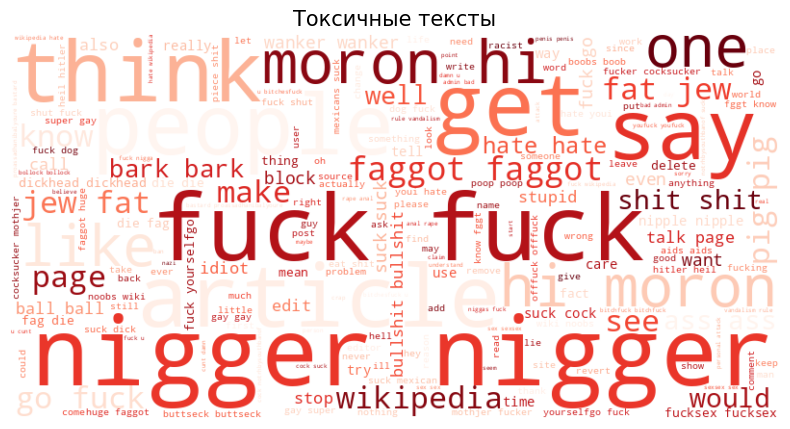

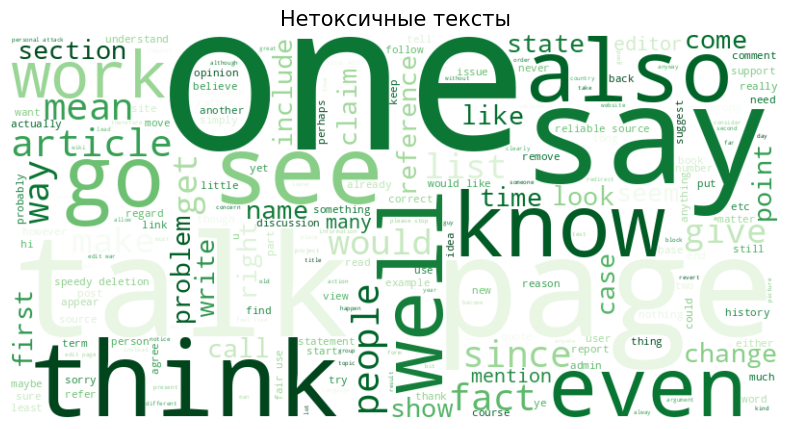

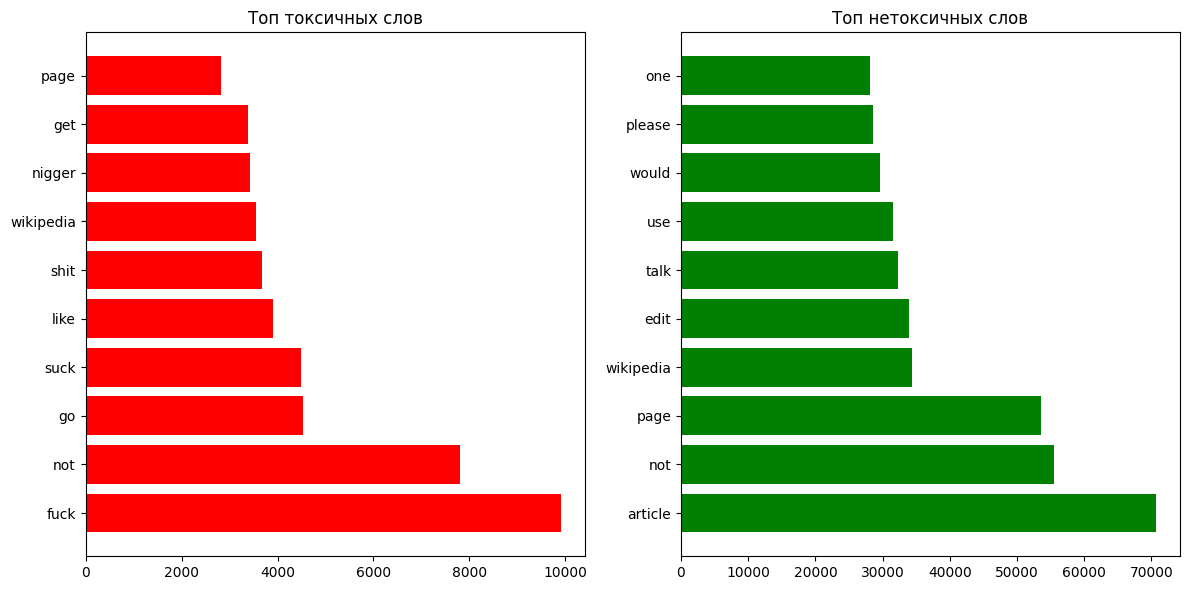

In [11]:
def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)


toxic_texts = result_df[result_df['toxic'] == 1]['processed_text']
normal_texts = result_df[result_df['toxic'] == 0]['processed_text']

print("Топ токсичных слов:", get_top_words(toxic_texts))
print("Топ нетоксичных слов:", get_top_words(normal_texts))


def plot_wordcloud(text, title, colormap='viridis'):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap,
        stopwords=stop_words
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()


plot_wordcloud(' '.join(toxic_texts), "Токсичные тексты", 'Reds')
plot_wordcloud(' '.join(normal_texts), "Нетоксичные тексты", 'Greens')


def plot_top_words_compare(top_toxic, top_normal, n=10):
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.barh([w[0] for w in top_toxic[:n]], [w[1] for w in top_toxic[:n]], color='red')
    plt.title('Топ токсичных слов')

    plt.subplot(1,2,2)
    plt.barh([w[0] for w in top_normal[:n]], [w[1] for w in top_normal[:n]], color='green')
    plt.title('Топ нетоксичных слов')

    plt.tight_layout()
    plt.show()

plot_top_words_compare(get_top_words(toxic_texts), get_top_words(normal_texts))

Думаю то какие слова оказались в каких топах, видно достаточно ясно.

## Обучение
Обучим две модели а именно логистичекую регрессию предобученную модель distilbert, сравним их по показателям метрики f1

In [16]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


param_dist = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [3, 5],
    'vectorizer__max_df': [0.7, 0.85, 0.9],
    'classifier__C': loguniform(0.1, 10),
    'classifier__solver': ['liblinear']
}


cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


if len(x_train) > 20000:
    x_train_small, y_train_small = resample(x_train, y_train,
                                          n_samples=20000,
                                          random_state=42,
                                          stratify=y_train)
else:
    x_train_small, y_train_small = x_train, y_train

print("Начинаем ускоренный подбор гиперпараметров...")
search.fit(x_train_small, y_train_small)


best_pipeline = search.best_estimator_
best_pipeline.fit(x_train, y_train)


y_pred = best_pipeline.predict(x_test)
print(classification_report(y_test, y_pred))
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Начинаем ускоренный подбор гиперпараметров...
Fitting 2 folds for each of 15 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     28622
           1       0.73      0.81      0.77      3237

    accuracy                           0.95     31859
   macro avg       0.86      0.89      0.87     31859
weighted avg       0.95      0.95      0.95     31859

F1-score: 0.7725


Метрика F1 для логистической регрессии оказалась равна 0.77

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")



model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
train_dataset = Dataset.from_pandas(pd.DataFrame({"text": x_train, "label": y_train}))
test_dataset = Dataset.from_pandas(pd.DataFrame({"text": x_test, "label": y_test}))

train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=32)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=32)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])





model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)  

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    num_train_epochs=3,
    eval_strategy="no",
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none",
    fp16=True,
    no_cuda=False,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "f1": f1_score(labels, preds, average='binary'),
        "accuracy": accuracy_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
)

print("Начало обучения...")
trainer.train()

output_dir = "/content/drive/MyDrive/toxicity_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Модель сохранена в {output_dir}")

Используемое устройство: cuda


Map:   0%|          | 0/127433 [00:00<?, ? examples/s]

Map:   0%|          | 0/31859 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Начало обучения...


Step,Training Loss
50,0.264700
100,0.161400
150,0.132800
200,0.136000
250,0.137300
300,0.135400
350,0.135400
400,0.146800
450,0.112700
500,0.125300


Модель сохранена в /content/drive/MyDrive/toxicity_model


In [26]:
print("\nИтоговая метрики на тестовых данных:")
eval_results = trainer.evaluate(test_dataset)
print(f"F1-score: {eval_results['eval_f1']:.4f}")


Итоговая метрики на тестовых данных:


F1-score: 0.8146


Метрика F1 для предобученной модели оказалась равна 0.81

## Выводы

Данные были преобразованы, а модели обучены, метрика f1 оказалась слегка выше у модели bert, но при этом это более сложнаяя модель и её обучение требует больше ресурсов и времени, но если безнес готов предоставить эти самые ресурсы, то лучше воспользоваться ей, ведь её предсказания будут более точными и адекватными.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны